In [2]:
from IPython.display import display
import msprime
import tskit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Basic `msprime` simulation setup

In [3]:
# simulate
ts = msprime.sim_ancestry(
        samples=100,
        population_size=1000,
        sequence_length=1_000,
        recombination_rate=0)
# mutate
ts = msprime.sim_mutations(ts, rate=1e-06)

The aim is to extract the two most frequent mutations, and get a table of their respective frequencies and the $r^2$ between them. 

So, first I make a function to compute allele frequencies for each of the variable sites.

Problem: this (and much of what happens downstream) will not work if more than one mutation occurs at a site. Explored more later...

In [4]:
# function to calculate allele frequencies - borrowed from https://github.com/tskit-dev/tskit/issues/504
def allele_frequencies(ts, sample_sets=None):
    # option to specify samples
    if sample_sets is None:
        sample_sets = [ts.samples()] 
    # get number of samples
    n = np.array([len(x) for x in sample_sets])
    # frequency calculator
    def f(x):
        return x / n
    return ts.sample_count_stat(sample_sets, 
                                f, # apply the frequency calculator
                                len(sample_sets),
                                windows='sites',
                                polarised=True,
                                mode='site',
                                strict=False,
                                span_normalise=False)

In [5]:
# get positions and frequencies
pos=ts.tables.sites.position # for future reference- you get the positions of mutations by looking in the tables
freqs=allele_frequencies(ts) # getting allele frequencies

In [6]:
muts=pd.DataFrame(arr,columns=["position","frequency"]) # get the mutations
muts=muts.sort_values(by='frequency', ascending=False) # sort by frequency
inds=list(muts[:2].index) # get the indives of the top 2
fs=list(muts[:2].frequency) # and their frequencies

    position  frequency
5        100      0.655
14       558      0.655
13       556      0.655
12       462      0.655
15       588      0.260
11       435      0.195
17       640      0.195
1         40      0.195
10       412      0.150
19       827      0.150
16       633      0.085
0         35      0.050
8        360      0.025
3         69      0.025
18       701      0.015
9        397      0.010
6        207      0.010
4         82      0.010
7        259      0.005
2         42      0.005
20       990      0.005


Now computing LD.

In [7]:
corr=tskit.LdCalculator(ts).r2(inds[0],inds[1]) # using the tskit function
(corr,fs[0],fs[1]) # outputting the r2 and the frequency of top 2 mutations

(0.9999999999999999, 0.655, 0.655)

Note: could modify the above so that it gives an r2 matrix of all the mutations, not just the top 2. 

# Scaling up the simulation set-up

Now, need to scale this set-up up so that I can get a bunch of values for a bunch of reps. Let's put all of the above in functions, and let's put it within another function which makes replicates. I'll also print the number of times the analysis fails. 

In [126]:
def get_row(ts):
    # get positions and frequencies
    pos=ts.tables.sites.position 
    freqs=allele_frequencies(ts).T.tolist()[0]
    # stick them in an array
    arr=np.column_stack((pos,freqs))
    # sort by frequency 
    muts=np.argsort(freqs)[::-1][:2] # the indices of the top 2 mutations
    fs=arr[muts,1] # their frequencies
    corr=tskit.LdCalculator(ts).r2(muts[0],muts[1]) # calculate LD
    row = np.array([[corr,fs[0],fs[1]]]) # make a row to append to an array
    return(row)

In [156]:
def sim_replicates(sample_size=100,
                   num_replicates=1,
                   mutation_rate=2e-8,
                   pop_size=10_000,
                   seq_length=1000,
                   mut_rate=1e-7,
                   quiet=True):
    # intialise array
    arr=np.empty([0,3])
    # simulate
    ancestry_reps = msprime.sim_ancestry(
        samples=sample_size,
        population_size=pop_size,
        sequence_length=seq_length,
        num_replicates=num_replicates)
    # extract info from tree sequences
    for ts in ancestry_reps: # get each ts
        mutated_ts = msprime.sim_mutations(ts, rate=mut_rate) # mutate
        # get the frequencies and r2 and iteratively add to arr
        try:
            r=get_row(mutated_ts)
            arr=np.vstack((arr,r))
            arr=pd.DataFrame(arr)
            arr.columns =['r2', 'f1', 'f2']
        # handling the failing due to recurrent mutations at a site
        except Exception as e:
            # in development- troubleshooting here
            if quiet==False:
                print(e,mutated_ts.tables.sites)
                #s=mutated_ts.tables.sites.position[~np.unique(mutated_ts.tables.sites.position,return_index=True)[1]]
                print(s)
            #print("failed\t")  
            pass
    print(f"Failed {100-(arr.shape[0]/num_replicates) * 100}% of attempts.")
    return(arr)

In [157]:
sim_replicates(100,10,mut_rate=1e-6,quiet=False)

Only infinite sites mutations are supported for this operation, i.e. at most a single mutation per site. (TSK_ERR_ONLY_INFINITE_SITES) ╔═══╤════════╤═══════════════╤════════╗
║id │position│ancestral_state│metadata║
╠═══╪════════╪═══════════════╪════════╣
║0  │       5│              G│        ║
║1  │       7│              G│        ║
║2  │      12│              C│        ║
║3  │      24│              A│        ║
║4  │      31│              A│        ║
║5  │      33│              G│        ║
║6  │      34│              G│        ║
║7  │      43│              A│        ║
║8  │      46│              A│        ║
║9  │      48│              G│        ║
║10 │      51│              A│        ║
║11 │      52│              A│        ║
║12 │      60│              G│        ║
║13 │      61│              A│        ║
║14 │      62│              C│        ║
║15 │      72│              A│        ║
║16 │      74│              C│        ║
║17 │      87│              G│        ║
║18 │      96│           

NameError: name 's' is not defined

In [127]:
df=sim_replicates(100,10_000) # let's see if it works! Simulate 10,000 replicates where we sample 100 individuals
# default options for all other parameters

Failed 5.329999999999998% of attempts.


In [48]:
# taking a look at the table of results
df = pd.DataFrame(df)
df.columns =['r2', 'f1', 'f2']
df

,r2,f1,f2
0,1.000000,0.585,0.585
1,1.000000,0.645,0.645
2,0.192492,0.790,0.420
3,1.000000,0.540,0.540
4,0.816092,0.750,0.710
...,...,...,...
9396,1.000000,0.645,0.645
9397,0.003154,0.080,0.035
9398,1.000000,0.505,0.505
9399,0.082913,0.255,0.195


# Preliminary data exploration...

Plotting time! Firstly, the 'joint frequency spectrum' of the top 2 most frequent mutations (note: does selecting the top 2 introduce a bias?).

(array([[  2.,   6.,   2., ...,   0.,   0.,   0.],
        [  2.,   9.,   8., ...,   0.,   0.,   0.],
        [  0.,   5.,   7., ...,   0.,   0.,   0.],
        ...,
        [  0.,   1.,   2., ..., 228.,   0.,   0.],
        [  0.,   1.,   3., ...,   2., 229.,   0.],
        [  1.,   0.,   0., ...,   2.,   0., 201.]]),
 array([0.045  , 0.06875, 0.0925 , 0.11625, 0.14   , 0.16375, 0.1875 ,
        0.21125, 0.235  , 0.25875, 0.2825 , 0.30625, 0.33   , 0.35375,
        0.3775 , 0.40125, 0.425  , 0.44875, 0.4725 , 0.49625, 0.52   ,
        0.54375, 0.5675 , 0.59125, 0.615  , 0.63875, 0.6625 , 0.68625,
        0.71   , 0.73375, 0.7575 , 0.78125, 0.805  , 0.82875, 0.8525 ,
        0.87625, 0.9    , 0.92375, 0.9475 , 0.97125, 0.995  ]),
 array([0.015 , 0.0395, 0.064 , 0.0885, 0.113 , 0.1375, 0.162 , 0.1865,
        0.211 , 0.2355, 0.26  , 0.2845, 0.309 , 0.3335, 0.358 , 0.3825,
        0.407 , 0.4315, 0.456 , 0.4805, 0.505 , 0.5295, 0.554 , 0.5785,
        0.603 , 0.6275, 0.652 , 0.6765, 0.70

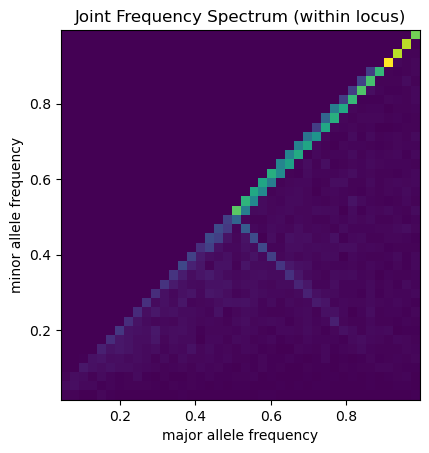

In [49]:
plt.clf()
plt.title('Joint Frequency Spectrum (within locus)')
plt.xlabel('major allele frequency')
plt.ylabel('minor allele frequency')
plt.axis('square')
plt.hist2d(df['f1'], df['f2'],bins=40)

Interesting diagonal stripe! 

Next, how does the LD between two sites change as a function of their frequency? I'll first attack this in 2D by summarising the mutation frequencies as a mean and difference (heatmap was more complicated than I thought). 

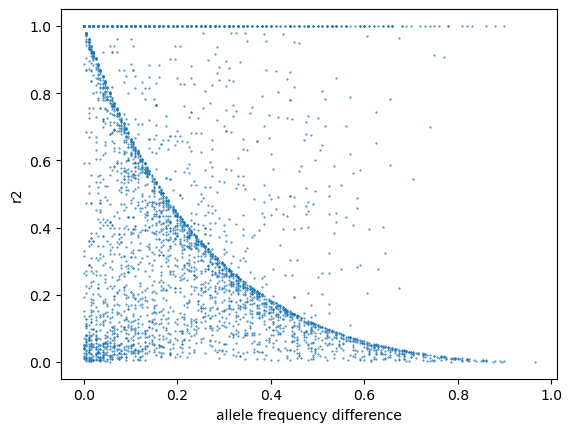

In [50]:
plt.clf()
plt.xlabel('allele frequency difference')
plt.ylabel('r2')
plt.scatter((df['f1']-df['f2']), df['r2'],s=0.2)
plt.savefig('r2_simplot.pdf')

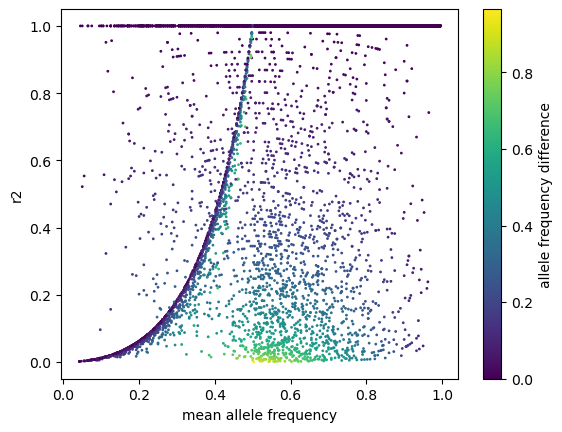

In [51]:
plt.clf()
plt.xlabel('mean allele frequency')
plt.ylabel('r2')
plt.scatter((df['f1']+df['f2'])/2, df['r2'],c=(df['f1']-df['f2']),s=1)
#plt.yscale('log')
plt.colorbar(label='allele frequency difference')
plt.savefig('r2_simplot_2.pdf')

Top line: two mutations occur on same branch in tree, so are occurring on the same haplotype only. Curve: not quadratic (check with log scale!) - not sure what's going on there yet. Maybe (inspired by https://www.sciencedirect.com/science/article/pii/S0040580908000609), this is the maximum $r^2$ between two alleles of that mean frequency, that are not on the same haplotype? I feel like this is a mixture of different configuration scenarios, and could be best explained via tree-based statistics. - note: it is different configuration scenarios! See R markdown.

Getting to a binned plot of r2 by frequency...

In [17]:
cuts = pd.DataFrame({str(feature) + 'Bin' : pd.cut(df['f1'], 10) for feature in ['f1','f2']})

cuts

,f1Bin,f2Bin
0,"(0.897, 0.995]","(0.897, 0.995]"
1,"(0.701, 0.799]","(0.701, 0.799]"
2,"(0.505, 0.603]","(0.505, 0.603]"
3,"(0.407, 0.505]","(0.407, 0.505]"
4,"(0.897, 0.995]","(0.897, 0.995]"
...,...,...
9428,"(0.701, 0.799]","(0.701, 0.799]"
9429,"(0.211, 0.309]","(0.211, 0.309]"
9430,"(0.799, 0.897]","(0.799, 0.897]"
9431,"(0.701, 0.799]","(0.701, 0.799]"


In [18]:
print(df.join(cuts))
means = df.join(cuts).groupby( list(cuts) )
means = means.mean()
means = means.unstack(level = 0) # Use level 0 to put 0Bin as columns.

# Reverse the order of the rows as the heatmap will print from top to bottom.
means = means.iloc[::-1]
print(means['r2'])

            r2     f1     f2           f1Bin           f2Bin
0     1.000000  0.960  0.960  (0.897, 0.995]  (0.897, 0.995]
1     1.000000  0.790  0.790  (0.701, 0.799]  (0.701, 0.799]
2     1.000000  0.570  0.430  (0.505, 0.603]  (0.505, 0.603]
3     0.394065  0.485  0.295  (0.407, 0.505]  (0.407, 0.505]
4     1.000000  0.905  0.905  (0.897, 0.995]  (0.897, 0.995]
...        ...    ...    ...             ...             ...
9428  1.000000  0.770  0.770  (0.701, 0.799]  (0.701, 0.799]
9429  1.000000  0.285  0.285  (0.211, 0.309]  (0.211, 0.309]
9430  0.123596  0.890  0.500  (0.799, 0.897]  (0.799, 0.897]
9431  1.000000  0.785  0.785  (0.701, 0.799]  (0.701, 0.799]
9432  1.000000  0.945  0.945  (0.897, 0.995]  (0.897, 0.995]

[9433 rows x 5 columns]
f1Bin           (0.014, 0.113]  (0.113, 0.211]  (0.211, 0.309]  \
f2Bin                                                            
(0.897, 0.995]             NaN             NaN             NaN   
(0.799, 0.897]             NaN             Na

<AxesSubplot: xlabel='f1Bin', ylabel='f2Bin'>

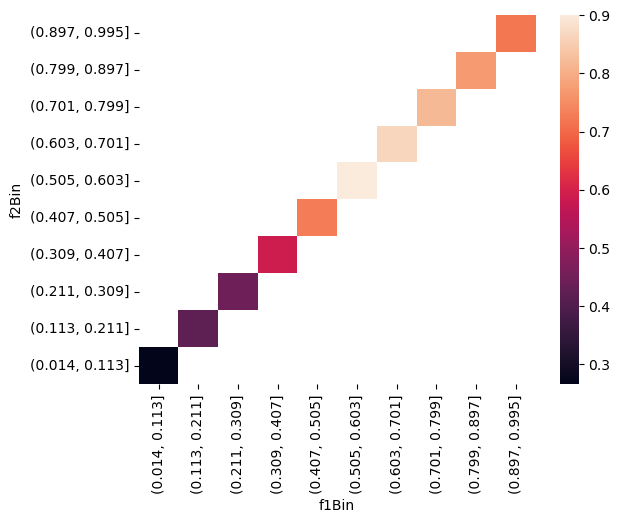

In [19]:
plt.clf()
sns.heatmap(means['r2']) 

Not really sure what is happening with this plot. I would do almost anything to tidyverse this instead. 

Next step: varying mutation rate. 

In [20]:
mut_res = {}
for rate in [1e-9,5e-9,1e-8,5e-8,1e-7,5e-7]:
    print(f'mutation rate={rate}')
    rsm = sim_replicates(100,1000,mut_rate=rate)
    mut_res[rate]=rsm

mutation rate=1e-09
Failed 97.5% of attempts.
mutation rate=5e-09
Failed 67.4% of attempts.
mutation rate=1e-08
Failed 35.2% of attempts.
mutation rate=5e-08
Failed 2.1000000000000085% of attempts.
mutation rate=1e-07
Failed 5.5% of attempts.
mutation rate=5e-07
Failed 48.5% of attempts.


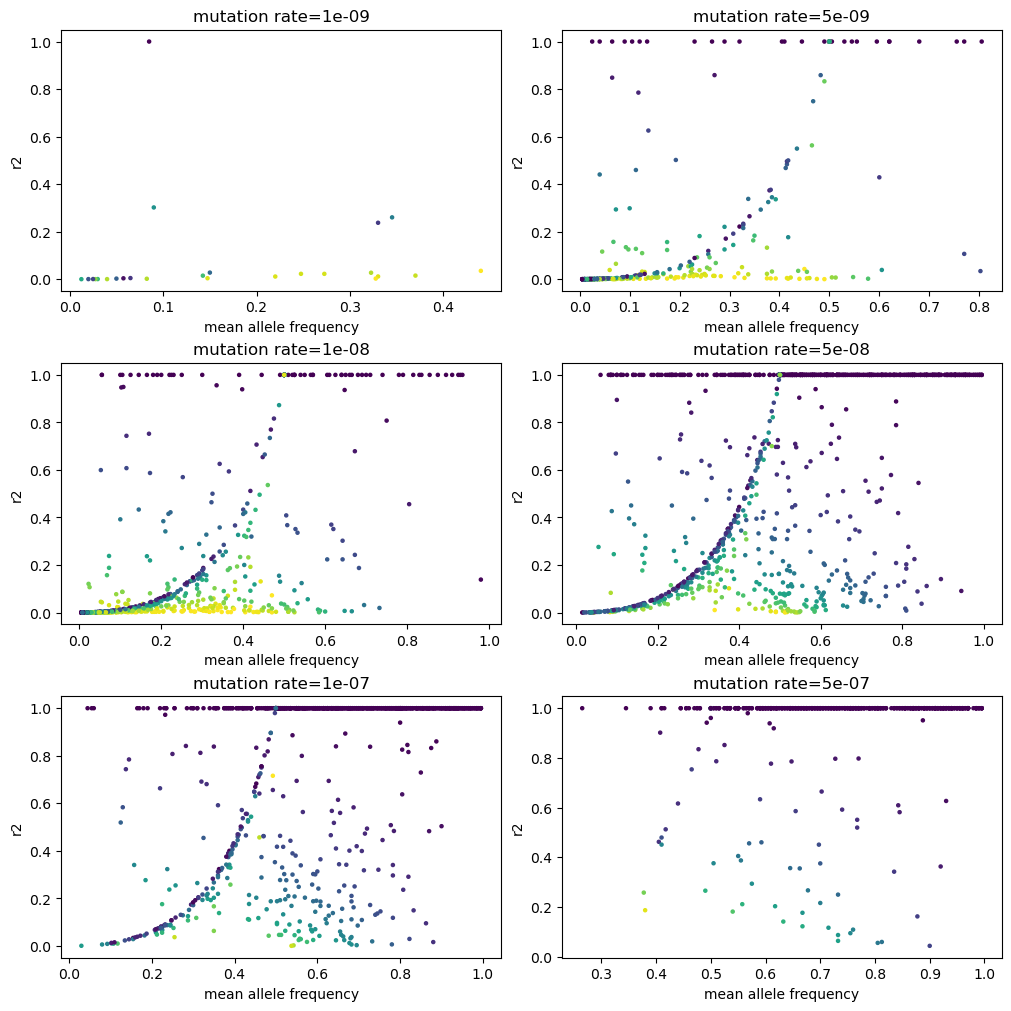

In [23]:
fig, axs = plt.subplots(3, 2, constrained_layout=True,figsize=(10, 10))

for ax, mr in zip(axs.flat, mut_res):
    dfm=mut_res[mr]
    ax.set_title(f'mutation rate={mr}')
    ax.set_xlabel('mean allele frequency')
    ax.set_ylabel('r2')
    ax.scatter((dfm['f1']+dfm['f2'])/2, dfm['r2'],c=(dfm['f1']-dfm['f2'])/(dfm['f1']+dfm['f2']),s=5)

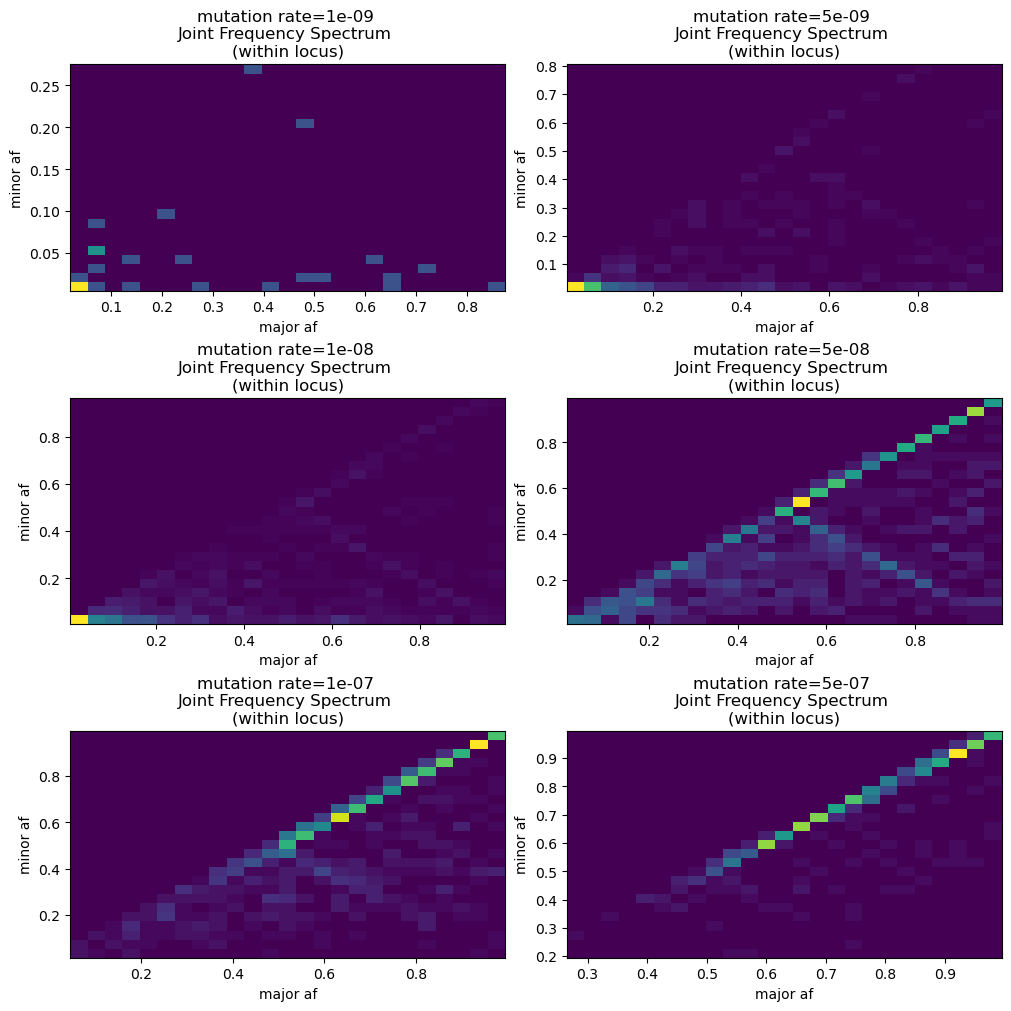

In [24]:
fig, axs = plt.subplots(3, 2, constrained_layout=True,figsize=(10, 10))

for ax, mr in zip(axs.flat, mut_res):
    dfm=mut_res[mr]
    ax.set_title(f'mutation rate={mr} \nJoint Frequency Spectrum \n(within locus)')
    ax.set_xlabel('major af')
    ax.set_ylabel('minor af')
    ax.hist2d(dfm['f1'], dfm['f2'],bins=25)

Why all this failing when we play with the mutation rate?

In [25]:
mut_res = {}
for rate in [1e-9,1e-8,1e-5]:
    print(f'mutation rate={rate}')
    rsm = sim_replicates(100,1,mut_rate=rate,quiet=False)
    mut_res[rate]=rsm

mut_res

mutation rate=1e-09
all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 0 and the array at index 1 has size 1
Failed 100.0% of attempts.
mutation rate=1e-08
Failed 0.0% of attempts.
mutation rate=1e-05
Only infinite sites mutations are supported for this operation, i.e. at most a single mutation per site. (TSK_ERR_ONLY_INFINITE_SITES)
Failed 100.0% of attempts.


{1e-09: array([], shape=(0, 3), dtype=float64),
 1e-08:     r2    f1    f2
 0  1.0  0.28  0.28,
 1e-05: array([], shape=(0, 3), dtype=float64)}

* When the mutation rate is too low, there simply are no mutations in the mutations table to report. This is a somewhat happy error (fix by adding a row with two zero frequency mutations?)
* When the mutation rate is too high, we get a tskit error. This error occurs when infinite sites is breached - specifically, the tskit LD calculations can't deal with more than one mutation happening at one site. Ways around this:
    * longer sequence. Not really a solution.
    * fewer individuals in population. Not really a solution. 
    * deal with LD in a different way when this happens, for example by directly computing the correlation between sites (maybe in the genotype matrix?). This will also let us see the sign of LD (currently not supported by the tskit LD calculator).
    
    
   r2 between major allele at each site

## Exploring alternate methods for getting LD manually without relying on `tskit`

Getting LD via a haplotype matrix...

In [28]:
nsamp=100
ts = msprime.sim_ancestry(
        samples=nsamp,
        population_size=10_000,
        sequence_length=1_000,
        recombination_rate=0)
# mutate
ts = msprime.sim_mutations(ts, rate=1e-06)
# get genotype matrix
g = np.array(ts.genotype_matrix())
print(g)
print(g.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(227, 200)


We have n rows (variable sites) by 200 columns (sample haplotypes). And yet! We have some '2' values in our matrix! How can this be?

In [29]:
# compute allele frequency
afs=np.sum(g,axis=1)/(2*nsamp)
# print(afs) # by array
# print(allele_frequencies(ts).T) # by tskit
# sanity check- they agree
print(afs)
print(afs.shape) # n columns for variable sites

[0.005 0.2   0.015 0.145 0.005 0.8   0.015 0.415 0.005 0.035 0.015 0.015
 0.015 0.015 0.055 0.14  0.06  0.05  0.065 0.01  0.22  0.22  0.58  0.22
 0.01  0.14  0.8   0.58  0.06  0.11  0.8   0.005 0.005 0.2   0.58  0.8
 0.2   0.01  0.04  0.045 0.005 0.58  0.8   0.025 0.58  0.14  0.64  0.425
 0.8   0.2   0.005 0.8   0.005 0.055 0.035 0.22  0.145 0.22  0.58  0.09
 0.005 0.03  0.58  0.58  0.09  0.8   0.2   0.005 0.2   0.03  0.04  0.01
 0.005 0.225 0.035 0.005 0.8   0.005 0.22  0.58  0.01  0.22  0.42  0.055
 0.215 0.02  0.2   0.8   0.2   0.02  0.03  0.22  0.2   0.58  0.8   0.05
 0.2   0.2   0.12  0.005 0.2   0.13  0.205 0.23  0.2   1.38  0.2   0.2
 0.015 0.055 0.2   0.8   0.02  0.005 0.005 0.8   0.035 0.14  0.58  0.005
 0.42  0.035 0.2   0.8   0.8   0.025 0.2   0.045 0.205 0.22  0.02  0.08
 0.01  0.825 0.58  0.58  0.005 0.8   0.035 0.58  0.005 0.055 0.22  0.8
 0.58  0.2   0.8   0.015 0.8   0.22  0.22  0.005 0.005 0.8   0.055 0.22
 0.04  0.145 0.06  0.8   0.8   0.015 0.27  0.005 0.01  0.22  1.

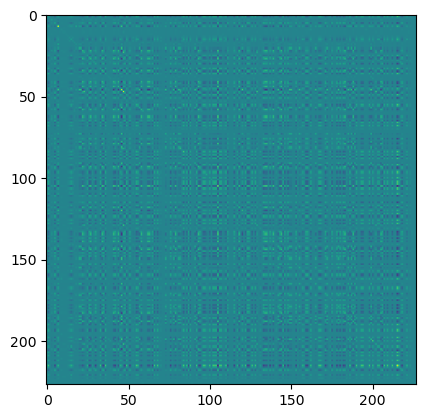

In [30]:
# compute cov
cv=np.cov(g)
# let's do an LD plot
plt.imshow(cv)

In [32]:
top = np.argsort(afs)[::-1][:2]
print(afs[top])
# sanity check: dimensions
print(g[top,:].shape)
# sanity check: agrees with tskit?
print(np.cov(g[top,:])[0,1])
print(g[top,:]>1)
print(g[top,:])
r=get_row(ts)
print(r)
pos=ts.tables.sites.position
freqs=allele_frequencies(ts)
arr=np.column_stack((pos,freqs))
muts=pd.DataFrame(arr,columns=["position","frequency"])
muts=muts.sort_values(by='frequency', ascending=False)
print(muts)

[1.38 1.  ]
(2, 200)
0.0
[[ True  True  True  True False  True  True False  True False  True False
  False  True  True False  True  True False  True False  True False False
   True  True False  True  True False  True False  True  True  True False
   True False  True False  True  True False  True  True  True  True  True
  False False  True False False False  True False  True False False  True
   True False  True  True  True False False False  True False  True  True
   True  True  True  True False False  True False False  True  True  True
   True False False  True False  True False  True  True False  True False
   True False False False  True False  True False  True  True  True False
   True False  True  True False  True  True  True  True False  True False
   True  True  True  True  True  True  True  True False False False  True
   True  True  True False  True  True False False False False False  True
  False False  True  True  True  True  True  True  True  True False False
   True  True

LibraryError: Only infinite sites mutations are supported for this operation, i.e. at most a single mutation per site. (TSK_ERR_ONLY_INFINITE_SITES)

This is baffling to me, why is the array 200 long (2xnumber of samples), yet we have the genotypes???

# Tree-based statistics

#### How many times is the minor mutation (node b) below the major mutation (node a)?

#### What is the shared branch length between the mutations?

Let's define the major mutation as the most common mutation at a locus, and the minor as the second most common. In what proportion of trees is the minor one below the major one, as opposed to somewhere else in the tree?

To answer this, first we simulate a small locus, as above:

In [33]:
nsamp=100
ts = msprime.sim_ancestry(
        samples=nsamp,
        population_size=10_000,
        sequence_length=1_000,
        recombination_rate=0, random_seed=4321)
# mutate
ts = msprime.sim_mutations(ts, rate=1e-07, random_seed=4321)

ts

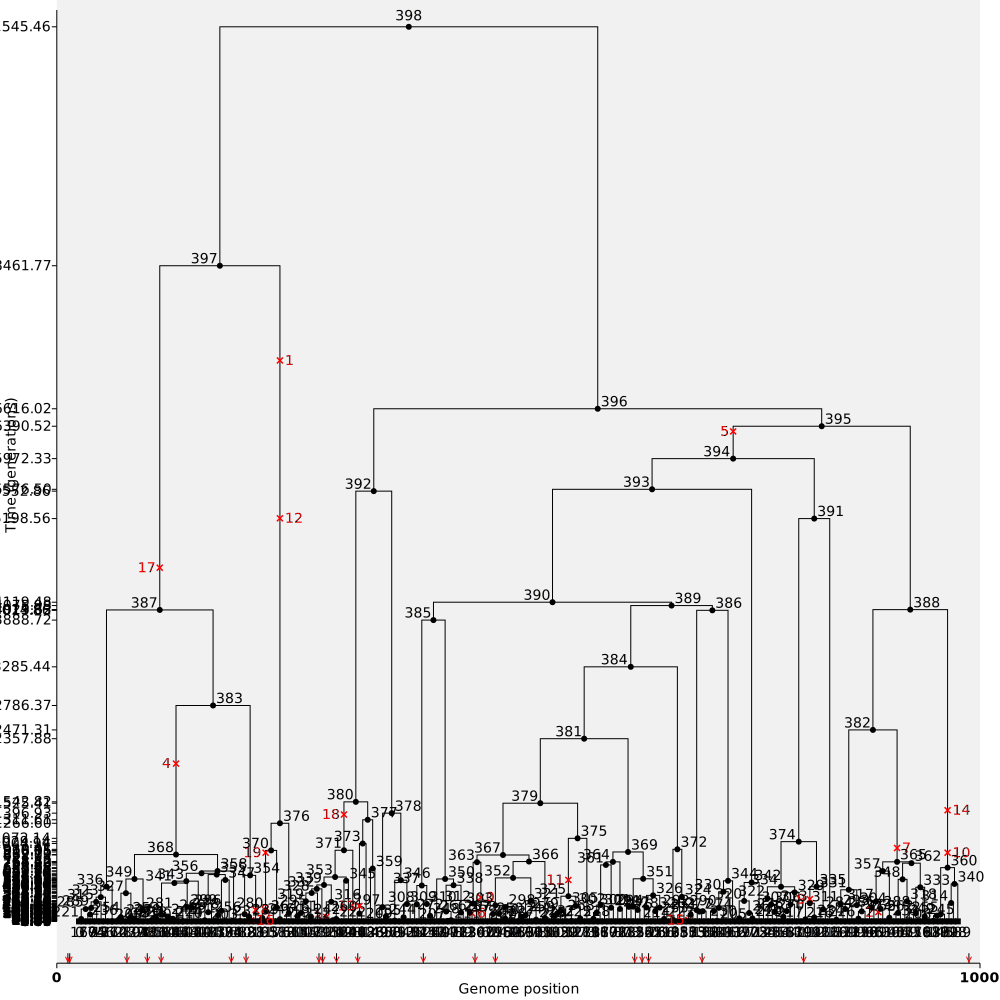

In [34]:
# make a dictionary of all the nodes below a given node
below={}
for tree in ts.trees():
    t=tree
    n_node=np.array(ts.tables.nodes).shape[0]
    for i in np.arange(0,n_node):
        below[i]=[u for u in t.nodes(i)]

ts.draw_svg(size=(1000,1000),y_axis=True)

In [35]:
g = np.array(ts.genotype_matrix())
g.shape
afs=np.sum(g,axis=1)/(2*nsamp)
print(afs)
print(ts.tables.mutations)
print([u for u in t.nodes(396)])

[0.005 0.04  0.005 0.005 0.135 0.475 0.005 0.07  0.005 0.02  0.035 0.04
 0.04  0.01  0.035 0.005 0.005 0.205 0.07  0.015]
╔══╤════╤════╤═════════════╤═════════════╤══════╤════════╗
║id│site│node│time         │derived_state│parent│metadata║
╠══╪════╪════╪═════════════╪═════════════╪══════╪════════╣
║0 │   0│ 102│ 310.96285085│            G│    -1│        ║
║1 │   1│ 376│7239.46071283│            G│    -1│        ║
║2 │   2│  29│ 119.72539438│            A│    -1│        ║
║3 │   3│ 115│  57.85272286│            C│    -1│        ║
║4 │   4│ 368│2036.38304786│            T│    -1│        ║
║5 │   5│ 394│6323.41859463│            T│    -1│        ║
║6 │   6│ 139│ 105.13275688│            G│    -1│        ║
║7 │   7│ 365│ 947.29312976│            G│    -1│        ║
║8 │   8│  21│ 147.63767304│            T│    -1│        ║
║9 │   9│ 313│ 286.83575731│            T│    -1│        ║
║10│  10│ 360│ 886.93382567│            A│    -1│        ║
║11│  11│ 325│ 534.60569214│            T│    -1│   

The table shows the node above the mutation. So we want to extract the two most frequent mutations and their nodes, and check whether the mutation of node b is below that of node a.

Then - if the nodes are above/below each other, we can find the shared branch length as the difference in the mutation times. 

In [36]:
nds=np.array([afs.T,ts.tables.mutations.node,ts.tables.mutations.time])
nds

array([[5.00000000e-03, 4.00000000e-02, 5.00000000e-03, 5.00000000e-03,
        1.35000000e-01, 4.75000000e-01, 5.00000000e-03, 7.00000000e-02,
        5.00000000e-03, 2.00000000e-02, 3.50000000e-02, 4.00000000e-02,
        4.00000000e-02, 1.00000000e-02, 3.50000000e-02, 5.00000000e-03,
        5.00000000e-03, 2.05000000e-01, 7.00000000e-02, 1.50000000e-02],
       [1.02000000e+02, 3.76000000e+02, 2.90000000e+01, 1.15000000e+02,
        3.68000000e+02, 3.94000000e+02, 1.39000000e+02, 3.65000000e+02,
        2.10000000e+01, 3.13000000e+02, 3.60000000e+02, 3.25000000e+02,
        3.76000000e+02, 2.60000000e+02, 3.60000000e+02, 3.70000000e+01,
        1.88000000e+02, 3.87000000e+02, 3.71000000e+02, 2.80000000e+02],
       [3.10962851e+02, 7.23946071e+03, 1.19725394e+02, 5.78527229e+01,
        2.03638305e+03, 6.32341859e+03, 1.05132757e+02, 9.47293130e+02,
        1.47637673e+02, 2.86835757e+02, 8.86933826e+02, 5.34605692e+02,
        5.20220049e+03, 1.98090951e+02, 1.43457472e+03, 1.6867

In [37]:
# get two most common mutations
top=np.argsort(afs.T)[::-1][:2]
print(top)
# indices
nds[:,top]

[ 5 17]


array([[4.75000000e-01, 2.05000000e-01],
       [3.94000000e+02, 3.87000000e+02],
       [6.32341859e+03, 4.56466066e+03]])

In [38]:
# checking for nodes below
print(nds[1,top])
print(below[nds[1,top[0]]])
bl= nds[1,top[1]] in below[nds[1,top[0]]] # bl is the indicator for one mutation being below the next
tdiff=ts.tables.mutations.time[top][1]-ts.tables.mutations.time[top][0] 
shared_branch_length= tdiff* bl # shared branch length is indicator for below-ness times time difference

shared_branch_length

[394. 387.]
[394, 391, 22, 374, 334, 322, 14, 306, 24, 270, 25, 55, 329, 130, 307, 81, 276, 151, 241, 34, 134, 335, 284, 96, 111, 313, 217, 79, 192, 234, 112, 141, 393, 342, 75, 320, 230, 12, 39, 263, 67, 229, 72, 103, 390, 385, 337, 308, 8, 54, 310, 121, 248, 126, 157, 350, 43, 338, 267, 78, 123, 272, 49, 211, 171, 207, 109, 148, 389, 384, 372, 214, 10, 185, 324, 28, 150, 381, 369, 351, 301, 283, 85, 122, 300, 23, 73, 326, 292, 223, 166, 193, 275, 45, 76, 294, 35, 162, 364, 287, 71, 80, 361, 291, 19, 108, 305, 187, 268, 87, 225, 15, 196, 379, 367, 363, 102, 312, 26, 266, 9, 139, 366, 232, 63, 86, 352, 303, 40, 298, 89, 258, 227, 147, 152, 257, 62, 206, 77, 195, 321, 215, 90, 125, 250, 131, 240, 177, 202, 48, 160, 375, 181, 325, 279, 129, 259, 101, 247, 18, 105, 302, 204, 32, 52, 228, 127, 173, 386, 282, 253, 37, 133, 274, 168, 271, 53, 155, 344, 91, 330, 113, 290, 116, 277, 38, 205, 124, 183]


-0.0

In [39]:
# checking for nodes below- with two that actually are below
print(nds[1,[1,12]])
print(below[nds[1,top[1]]])
bl= nds[1,12] in below[nds[1,1]] 
print(ts.tables.mutations.time[12])
print(ts.tables.mutations.time[1])
tdiff=ts.tables.mutations.time[1]-ts.tables.mutations.time[12]
shared_branch_length= tdiff* bl

shared_branch_length

[376. 376.]
[387, 336, 200, 36, 170, 323, 46, 315, 17, 289, 95, 285, 221, 0, 167, 254, 70, 174, 383, 354, 21, 256, 203, 4, 50, 239, 88, 188, 368, 349, 281, 7, 98, 327, 236, 2, 143, 238, 27, 220, 30, 194, 358, 74, 356, 343, 159, 341, 252, 237, 156, 213, 11, 186, 243, 110, 224, 184, 218, 114, 146, 299, 201, 47, 163, 296, 104, 140, 355, 269, 117, 210, 20, 144, 347, 191, 278, 106, 251, 83, 158]
5202.200487736631
7239.460712829252


2037.260225092621

Now, I want to scale this up so that I can do it for all my simulation repeats. This will let me determine which of the two tree topology configurations the mutations are in (one under the other versus two different branches). This is important because it leads to different LD patterns. By getting an idea of:
* how probable a given configuration is
* the probability of having a given frequency configuration of the two mutations
We can work out the expected LD pattern!

In [95]:
def get_nodes_below(ts):
    # make a dictionary of all the nodes below a given node
    below={}
    for tree in ts.trees():
        t=tree
        n_node=np.array(ts.tables.nodes).shape[0]
        for i in np.arange(0,n_node):
            below[i]=[u for u in t.nodes(i)]
    return(below)

def is_node_below(ts,node_above,node_below):
    node_above=int(node_above)
    node_below=int(node_below)
    # make a dictionary of all the nodes below a given node
    # this should be more efficient than the above
    # messy setup
    for tree in ts.trees():
        t=tree
        is_below=node_below in t.nodes(node_above)
    return(is_below)

def get_time_diff(ts,mut_1,mut_2):
    mut_1=int(mut_1)
    mut_2=int(mut_2)
    tdiff=ts.tables.mutations.time[mut_1]-ts.tables.mutations.time[mut_2]
    return(np.sqrt(tdiff**2))

def get_shared_branch_length(ts,mut_1,mut_2):
    muts=ts.tables.mutations.node
    node_above=muts[mut_1]
    node_below=muts[mut_2]
    # added or to allow either mutation to be above the other
    blw=is_node_below(ts,node_above,node_below) or is_node_below(ts,node_below,node_above)
    tdiff=get_time_diff(ts,mut_1,mut_2)
    sbl=tdiff*blw
    return(sbl)

In [98]:
# checking that this works
is_node_below(ts,int(nds[1,12]),int(nds[1,1]))
tdiff=get_time_diff(ts,12,1)
print(tdiff)
print(get_shared_branch_length(ts,12,1)) # works
print(get_shared_branch_length(ts,17,4)) # works
print(get_shared_branch_length(ts,4,17)) # works
print(get_shared_branch_length(ts,4,12)) # works

2037.260225092621
2037.260225092621
2528.277608275705
2528.277608275705
0.0


##### Scaling to repeat simulations

In [ ]:
def get_row(ts,return_index=F):
    # get positions and frequencies
    pos=ts.tables.sites.position
    freqs=allele_frequencies(ts)
    arr=np.column_stack((pos,freqs))
    muts=pd.DataFrame(arr,columns=["position","frequency"])
    muts=muts.sort_values(by='frequency', ascending=False)
    inds=list(muts[:2].index)
    fs=list(muts[:2].frequency)
    corr=tskit.LdCalculator(ts).r2(inds[0],inds[1])
    row = np.array([[corr,fs[0],fs[1]]])
    if return_index:
        return(row,index)
    else:
        return(row)

def sim_replicates_branch(sample_size=100,
                           num_replicates=1,
                           mutation_rate=2e-8,
                           pop_size=10_000,
                           seq_length=1000,
                           mut_rate=1e-7,
                           quiet=True):
    arr=np.empty([0,3])
    ancestry_reps = msprime.sim_ancestry(
        samples=sample_size,
        population_size=pop_size,
        sequence_length=seq_length,
        num_replicates=num_replicates)
    for ts in ancestry_reps:
        mutated_ts = msprime.sim_mutations(ts, rate=mut_rate)
        # add bit to get results
        try:
            r=get_row(mutated_ts,get_index=T)
            arr=np.vstack((arr,r[0]))
            mts=r[1]
            sbl=get_shared_branch_length(ts,mts[0],mts[1])
            print(sbl)
        except Exception as e:
            if quiet==False:
                print(e)
            #print("failed\t")  
            pass
    arr= pd.DataFrame(arr)
    arr.columns =['r2', 'f1', 'f2']
    print(f"Failed {100-(arr.shape[0]/num_replicates) * 100}% of attempts.")
    return(arr)

In [ ]:
df=sim_replicates_branch(100,10_000)

Note: I jsut calculated a pretty useless quantity- the waiting time between mutations. The shared branch length is actually something different...